# Testing Deferred Revenue in Python
Will this be easier for everyone to use than Matlab?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Processing Base Billings Data

In [2]:
df = pd.read_excel('../data/Data_2019_P06/base_billings.xlsx', sheet_name='bill_DC')

In [3]:
df.sample(10)

,Document Currency,Enterprise Bu,Frequency,Invoicing Fiscal Year-Period Desc,Product Configtype ID,Revenue Recognition Category New,Rule For Bill Date,Sales Type,Subscription Term,Completed Sales Doc Currency
30422,USD,Experience Cloud,CERT,2016-12,1Y,D,YQ,DEFERRED,12,6608.25
18325,GBP,Print & Publishing,NaN,2018-07,1Y,A,NaN,DEFERRED,12,22285.87
33341,USD,Print & Publishing,ONGO,2017-03,1Y,D,YA,DEFERRED,12,15000.00
7304,DKK,Creative,NaN,2017-04,NaN,D,Y3,DEFERRED,1,1776.00
6083,CHF,Document Cloud,NaN,2018-06,1Y,D,Y3,DEFERRED,1,26578.42
8104,DKK,Experience Cloud,NaN,2016-01,1Y,D,YA,DEFERRED,0,133332.00
20890,JPY,Experience Cloud,ONGO,2016-11,OENSV,D,NaN,DEFERRED,0,2400000.00
11114,EUR,Experience Cloud,1TME,2015-11,ONORE,NaN,NaN,RECOGNIZED,0,112644.43
1345,AUD,Document Cloud,NaN,2017-06,MTHLY,D,Y3,DEFERRED,1,40927.29
25849,USD,Creative,NaN,2015-10,1Y,A,NaN,DEFERRED,12,35103575.55


## Changing the column names early since they are inconsistent across other reports

In [4]:
df.columns

Index(['Document Currency', 'Enterprise Bu', 'Frequency',
       'Invoicing Fiscal Year-Period Desc', 'Product Configtype ID',
       'Revenue Recognition Category New', 'Rule For Bill Date', 'Sales Type',
       'Subscription Term', 'Completed Sales Doc Currency'],
      dtype='object')

In [5]:
df.rename(index = str, columns = {'Document Currency': 'curr',
                                 'Enterprise Bu': 'BU',
                                 'Invoicing Fiscal Year-Period Desc': 'period',
                                 'Product Configtype ID': 'config',
                                 'Rule For Bill Date': 'rebill_rule',
                                 'Completed Sales Doc Currency': 'amount'}, inplace=True)

In [6]:
df.columns

Index(['curr', 'BU', 'Frequency', 'period', 'config',
       'Revenue Recognition Category New', 'rebill_rule', 'Sales Type',
       'Subscription Term', 'amount'],
      dtype='object')

## Remove any currency that has  < 10 transactions. 


In [7]:
# creates a list of the currencies and the number of transactions for each currency
vc = df['curr'].value_counts()

In [8]:
# Create variable that is true if the number of transaction is greater than 10, false otherwise
keep_these = vc.values > 10
# filtering only currencies that were greater than 10
keep_curr = vc[keep_these]
a = keep_curr.index
# filtering the dataframe to remove any of teh currencies not in our list
df = df[df['curr'].isin(a)]

## Just keeping track of the currencies we removed in our model_dict data structure

In [9]:
remove_these = vc.values <= 10
model_dict = {'curr_removed': list(vc[remove_these].index)}
model_dict

{'curr_removed': ['ILS', 'BMD', 'INR', 'MXP', 'SAR']}

## Removing any of the values that are zero

In [10]:
print('This is the length of the dataframe before removing zeros: ', len(df))
df = df[df['amount']!=0]
print('This is the length of the dataframe after removing zeros: ', len(df))

This is the length of the dataframe before removing zeros:  33945
This is the length of the dataframe after removing zeros:  31263


In [11]:
df.sample(10)

,curr,BU,Frequency,period,config,Revenue Recognition Category New,rebill_rule,Sales Type,Subscription Term,amount
5998,CHF,Document Cloud,NaN,2017-10,MTHLY,A,NaN,DEFERRED,1,-138.80
32957,USD,Print & Publishing,NaN,2015-09,1Y,A,NaN,DEFERRED,1,-361.67
29661,USD,Experience Cloud,1TME,2016-02,NaN,D,YQ,DEFERRED,0,-461.02
24334,SEK,Creative,NaN,2018-03,1Y,A,NaN,DEFERRED,12,-270283.22
188,AUD,Creative,NaN,2016-01,NaN,D,Y3,DEFERRED,1,6518.23
11348,EUR,Experience Cloud,1TME,2016-04,OCONS,B,NaN,DEFERRED,0,166903.29
6782,CHF,LiveCycle,NaN,2017-07,NaN,NaN,NaN,RECOGNIZED,0,1040.00
25715,USD,Creative,NaN,2015-07,IDRT,NaN,NaN,RECOGNIZED,0,125549.00
16845,GBP,Experience Cloud,ONGO,2017-03,1Y,D,YQ,DEFERRED,0,126410.27
12488,EUR,Experience Cloud,ONGO,2018-03,1Y,D,Y3,DEFERRED,0,331.34


## Clearing out the Non-Revenue billings from the file
 - No Idea what these are

In [12]:
df['Sales Type'].value_counts()

DEFERRED       24902
RECOGNIZED      5355
PRO-SVC-INV      906
NON-REV          100
Name: Sales Type, dtype: int64

In [13]:
print('Length of the dataframe before removing non-revenue billings: ', len(df))
df = df[df['Sales Type']!='NON-REV']
print('Length of the dataframe after removing non-revenue billings:  ', len(df))


Length of the dataframe before removing non-revenue billings:  31263
Length of the dataframe after removing non-revenue billings:   31163


## Starting to group the revenue by period, industry, etc

Attempting to group by the following categories
 - currency
 - period
 - sale type
 
May need to process the data differently with the deferred billings so we will start with the recognized and then the service billings


DOING THIS ALL IN PANDAS WITH SPLIT APPLY COMBINE on Sales Type 


In [14]:
# First split the data into three dataframes
# Recognized billings
rec = df[df['Sales Type']=='RECOGNIZED']
svc = df[df['Sales Type']=='PRO-SVC-INV']
dfr = df[df['Sales Type']=='DEFERRED']

In [15]:
# Filter and group billings function will delete temporary datasets as completed
def filter_and_group(data2process, gblist, billings_type=None):
    """filter and group Base Billings Data"""
    
    #when a billings_type is supplied then filter, else just go to groupby below
    if billings_type:
        data2process = data2process[data2process['Revenue Recognition Category New']==billings_type]
    
    #groupby the columns passed in the function call then remove the subscription term column
    gb = data2process.groupby(gblist, as_index=False).sum()
    gb.drop(labels='Subscription Term', axis=1, inplace = True)
    return gb

In [16]:
gb_rec = filter_and_group( rec, ['curr', 'BU', 'period'])
gb_svc = filter_and_group( svc, ['curr', 'BU', 'period'])
gb_a = filter_and_group(dfr, ['curr', 'BU', 'period', 'config'],  'A')
gb_b = filter_and_group(dfr,['curr', 'BU', 'period'],  'B')
gb_d = filter_and_group(dfr,['curr', 'BU', 'period',
                     'rebill_rule'], 'D')

In [17]:
#rec.columns

## NOW WORKING ON THE BILLINGS

### Recognized Revenue

In [18]:
#rec.sample(10)

In [19]:
# testing groupby object
#gb_rec = rec.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [20]:
# the Subscription term hangs around. We are dropping that here
#gb_rec.drop(labels='Subscription Term', axis=1,inplace =True)

In [21]:
#gb_rec.sample(10)

In [22]:
#print(type(gb_rec))

### Service Billings

In [23]:
# testing groupby object
#gb_svc = svc.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [24]:
#gb_svc.drop(labels='Subscription Term', axis=1,inplace =True)
#gb_svc.head(5)

### NOW WORKING ON DEFERRED BILLINGS

Type B billings are service agreements that will have invoices submitted before the billings are reclassified to revenue. If no invoices are assigned to the billings, the billings become revenue in 12 months

In [25]:
# filter out the type B first then do a group_by
#dfr_b = dfr[dfr['Revenue Recognition Category New']=='B']

In [26]:
#gb_b = dfr_b.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [27]:
#gb_b.drop(labels='Subscription Term', axis=1, inplace=True)

In [28]:
#gb_b.head(10)

In [29]:
#print('length of deferred billings : ', len(dfr))
#print('length of the type B billings: ', len(dfr_b))

## Now Type A Billings
These billings are on a billing plan. The product config tells us how long before they renew

 - '2Y' = 24 months
 - '1Y' = 12 months
 - 'MTHLY' = 1 month
 
NOTE: There are also other fields in the 'Product Configtype ID' field that do not map well to a rebill period.
To fix this, we need to load up a different file and determine the length of the sales contract (type A no config)
 

In [30]:
# filtering just the type A billings
#dfr_a = dfr[dfr['Revenue Recognition Category New']=='A']

In [31]:
#gb_a = dfr_a.groupby(['curr', 'BU', 'period',
#                     'config'], as_index=False).sum()
#gb_a.drop(labels='Subscription Term', axis=1, inplace = True)

In [32]:
gb_a.sample(10)

,curr,BU,period,config,amount
3626,USD,LiveCycle,2019-03,1Y,276741.23
1100,DKK,Other Solutions,2016-11,OUNIV,11949.00
2092,GBP,Print & Publishing,2015-07,2Y,528.00
2469,JPY,Document Cloud,2018-10,2Y,22687.00
3049,SEK,Experience Cloud,2016-12,1Y,7354743.80
667,CHF,Creative,2016-01,MTHLY,-625.32
2823,NOK,Print & Publishing,2016-09,1Y,230.00
3119,USD,Creative,2015-09,2Y,236128.52
238,AUD,Document Cloud,2018-03,1Y,1050849.79
275,AUD,Document Cloud,2019-03,1Y,1390418.03


In [33]:
gb_a['config'].value_counts()

1Y       1936
MTHLY     829
2Y        693
OUNIV     178
OCONS      62
3Y         58
ONORE      29
Name: config, dtype: int64

### Below is just a check to see how large the billing types are across all periods

In [34]:
gb_a_config = gb_a.groupby(['config'], as_index=False).sum()
gb_a_config

,config,amount
0,1Y,7.195507e+10
1,2Y,2.080207e+08
2,3Y,1.560911e+08
3,MTHLY,-1.638659e+07
4,OCONS,2.883743e+07
5,ONORE,2.260631e+06
6,OUNIV,3.412069e+06


### These 'OCONS', 'ONORE' and 'OUNIV' data types are not actual product config IDs so we have to get them from a different data file. We are excluding these types below.

In [35]:
config_list = ['1Y', '2Y', '3Y', 'MTHLY']
test1 = gb_a['config'].isin(config_list)
sum(test1)

3516

In [36]:
test1 = gb_a[gb_a['config'].isin(config_list)]

## For now, lets just split this into gb_a_1Y, gb_a_2Y, gb_a_3y, gb_a_1M


In [37]:
gb_a_1Y = test1[test1['config']=='1Y']
gb_a_2Y = test1[test1['config']=='2Y']
gb_a_3Y = test1[test1['config']=='3Y']
gb_a_1M = test1[test1['config']=='MTHLY']

In [38]:
print('this is the lenght of type A 1M billings: ', len(gb_a_1M))
print('this is the lenght of type A 1Y billings: ', len(gb_a_1Y))
print('this is the lenght of type A 2Y billings: ', len(gb_a_2Y))
print('this is the lenght of type A 3Y billings: ', len(gb_a_3Y))

this is the lenght of type A 1M billings:  829
this is the lenght of type A 1Y billings:  1936
this is the lenght of type A 2Y billings:  693
this is the lenght of type A 3Y billings:  58


## TYPE D billings
These billings have a field 'Rule For Bill Date' that determines when new billings will occur
 - Monthly [Y1, Y2, Y3, Y5]
 - Quarterly [YQ]
 - Every 4 months [YT]
 - Semi-annual [YH]
 - Annual [YA, YC]
 - Every 2 years - [Y4]
 
 We also need to track the type D billings that do not have a 'Rule for Bill Date'

In [39]:
# for now just do a groupby on the type
# filtering just the type A billings
#dfr_d = dfr[dfr['Revenue Recognition Category New']=='D']

In [40]:
#gb_d = dfr_d.groupby(['curr', 'BU', 'period',
#                     'rebill_rule'], as_index=False).sum()
#gb_d.drop(labels='Subscription Term', axis=1, inplace = True)

In [41]:
gb_d_mthly = gb_d[gb_d['rebill_rule'].isin(['Y1', 'Y2', 'Y3', 'Y5'])]
gb_d_qtrly = gb_d[gb_d['rebill_rule']=='YQ']
gb_d_four_mths = gb_d[gb_d['rebill_rule']=='YT']
gb_d_semi_ann = gb_d[gb_d['rebill_rule']=='YH']
gb_d_annual = gb_d[gb_d['rebill_rule'].isin(['YA', 'YC'])]
gb_d_two_yrs = gb_d[gb_d['rebill_rule']=='Y4']

In [42]:
gb_d['rebill_rule'].value_counts()

YA    1799
Y3    1582
YQ     571
Y1     271
YC     255
YH     255
Y2      97
Y4      27
Y7      21
YT       8
BT       1
Name: rebill_rule, dtype: int64

### Note: There is one type D billings that is listed as 'BT' I don't know what this means, but it was a $180 EUR payment from January 2017, so we will ignore

In [43]:
print('Length of monthly', len(gb_d_mthly))
print('Length of quarterly', len(gb_d_qtrly))
print('Length of four months', len(gb_d_four_mths))
print('Length of semi ann', len(gb_d_semi_ann))
print('Length of annual', len(gb_d_annual))
print('Length of two years', len(gb_d_two_yrs))

Length of monthly 1950
Length of quarterly 571
Length of four months 8
Length of semi ann 255
Length of annual 2054
Length of two years 27


In [44]:
what_is_BT = gb_d[gb_d['rebill_rule']=='YT']
what_is_BT.head(10)

,curr,BU,period,rebill_rule,amount
4417,USD,Experience Cloud,2015-06,YT,11666.60
4431,USD,Experience Cloud,2015-08,YT,549861.11
4444,USD,Experience Cloud,2015-10,YT,11666.60
4464,USD,Experience Cloud,2016-01,YT,612916.60
4469,USD,Experience Cloud,2016-02,YT,-601250.00
4529,USD,Experience Cloud,2016-12,YT,13440.00
4553,USD,Experience Cloud,2017-04,YT,13440.00
4577,USD,Experience Cloud,2017-08,YT,13440.00


## Note: There are only 8 payments (back from 2017) that paid on a 4 month basis. 
We will ignore these as well.

## NOW WE NEED TO BUILD A DATAFRAME THAT INTEGRATES THIS DATA

- We will have the following descriptive fields
   - Invoicing Fiscal Year-Period
   - Document Currency
   - Enterprise BU

- We will have the following fields based on rebilling rule
   - Recognized
   - Service
   - Monthly
   - Quarterly
   - Annual
   - Two Years
   - Three Years

In [45]:
# We need to do it this way when we get to a .py file!
list_df = [gb_rec, gb_svc, gb_b,
        gb_a_1M,    gb_a_1Y,    gb_a_2Y,       gb_a_3Y, 
        gb_d_mthly, gb_d_qtrly, gb_d_semi_ann, gb_d_annual, gb_d_two_yrs]

list_columns = ['recognized', 'service', 'deferred_B', 
    'deferred_1M_a', 'deferred_1Y_a', 'deferred_2Y_a', 'deferred_3Y_a',
    'deferred_1M_d', 'deferred_3M_d', 'deferred_6M_d', 'deferred_1Y_d', 'deferred_2Y_d']


In [46]:
def merge_new_dataframe(old_df, new_df, new_column):
    df_merged = pd.merge(old_df, new_df, how='outer', 
                     left_on=['curr', 'BU', 'period'],
                    right_on=['curr', 'BU', 'period'])
    df_merged.rename(index=str, columns={'amount': new_column}, inplace=True)
    
    #need to drop the product configtype id for merges where the new_df is of type A
    config_str = 'config'
    rule_str = 'rebill_rule'
    if config_str in df_merged.columns:
        df_merged.drop(columns=['config'], inplace=True)
    
    if rule_str in df_merged.columns:
        df_merged.drop(columns=['rebill_rule'], inplace=True)
        
    return df_merged

In [47]:
def merge_all_dataframes(list_df, list_columns):
    for i, df in enumerate(list_df):
        print('This is i:', i)
        #print("This is the df: ", df.head())
        print('referencing the column: ', list_columns[i])

        if i==0:
            df_merged = list_df[0]
            df_merged.rename(index=str, columns={'amount': list_columns[i]}, inplace=True)
        else:
            df_merged = merge_new_dataframe(df_merged, df, list_columns[i])

    return df_merged
    

In [48]:
df = merge_all_dataframes(list_df, list_columns)

This is i: 0
referencing the column:  recognized
This is i: 1
referencing the column:  service
This is i: 2
referencing the column:  deferred_B
This is i: 3
referencing the column:  deferred_1M_a
This is i: 4
referencing the column:  deferred_1Y_a
This is i: 5
referencing the column:  deferred_2Y_a
This is i: 6
referencing the column:  deferred_3Y_a
This is i: 7
referencing the column:  deferred_1M_d
This is i: 8
referencing the column:  deferred_3M_d
This is i: 9
referencing the column:  deferred_6M_d
This is i: 10
referencing the column:  deferred_1Y_d
This is i: 11
referencing the column:  deferred_2Y_d


In [49]:
df.sample(10)

,curr,BU,period,recognized,service,deferred_B,deferred_1M_a,deferred_1Y_a,deferred_2Y_a,deferred_3Y_a,deferred_1M_d,deferred_3M_d,deferred_6M_d,deferred_1Y_d,deferred_2Y_d
83,AUD,Document Cloud,2017-02,331227.75,NaN,NaN,-360.84,352028.56,366.00,NaN,248960.34,NaN,NaN,440059.16,NaN
792,DKK,Other Solutions,2019-06,-779.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
905,EUR,Document Cloud,2016-09,3047108.46,NaN,NaN,-711.34,2014942.60,283662.00,NaN,312132.84,89300.00,NaN,4019071.64,NaN
619,DKK,Creative,2015-12,213241.00,NaN,NaN,-2210.67,-83239.92,NaN,NaN,6739714.20,NaN,NaN,1782167.26,NaN
1301,GBP,Document Cloud,2016-06,885859.51,NaN,3350.0,-430.29,537740.02,37325.49,NaN,187340.11,NaN,NaN,637211.25,NaN
3052,USD,Print & Publishing,2019-06,5182420.76,NaN,NaN,NaN,9047004.43,78797.00,NaN,2187.50,29599.31,NaN,35964.00,NaN
2508,USD,Creative,2016-07,6925454.15,80000.0,NaN,372128.10,54229171.50,118613.32,NaN,15286.79,133741.15,265083.34,20028921.69,NaN
1927,JPY,Print & Publishing,2018-07,9964075.00,NaN,NaN,NaN,5813748.00,NaN,NaN,847741.00,NaN,NaN,NaN,NaN
1991,NOK,Document Cloud,2015-06,98920.00,NaN,NaN,NaN,-386.47,NaN,NaN,240109.00,NaN,NaN,81321.58,NaN
574,CHF,Print & Publishing,2016-03,12092.00,NaN,NaN,NaN,NaN,NaN,NaN,3755.00,NaN,NaN,NaN,NaN


In [50]:
def clean_df_columns(df):
    
    # clean up NaNs before adding 
    df = df.fillna(value=0)
    
    # Monthly
    df['deferred_1M'] = df['deferred_1M_a']+df['deferred_1M_d']
    df.drop(labels=['deferred_1M_a', 'deferred_1M_d'], axis=1, inplace=True)
    
    # Annual
    df['deferred_1Y'] = df['deferred_1Y_a']+df['deferred_1Y_d']
    df.drop(labels=['deferred_1Y_a', 'deferred_1Y_d'], axis=1, inplace=True)
    
    # Two-Year
    df['deferred_2Y'] = df['deferred_2Y_a']+df['deferred_2Y_d']
    df.drop(labels=['deferred_2Y_a', 'deferred_2Y_d'], axis=1, inplace=True)
    
    # renaming 3Y, 3M and 6M
    df.rename(index=str, columns = {'deferred_3Y_a':'deferred_3Y', 'deferred_3M_d':'deferred_3M', 
                               'deferred_6M_d': 'deferred_6M'}, inplace=True)

    #cleaning up the longer column names
    df.rename(index=str, columns = {'curr': 'curr',
                               'BU':'BU',
                               'period':'period'}, inplace=True)
    
    return df

In [51]:
df = clean_df_columns(df)

In [52]:
df.sample(10)

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_3M,deferred_6M,deferred_1M,deferred_1Y,deferred_2Y
1346,GBP,Experience Cloud,2015-08,1.719388e+06,685406.92,143964.36,0.0,948833.58,21936.8,1.754917e+04,2.024630e+06,0.0
2169,RUB,Creative,2018-05,7.949000e+04,0.00,0.00,0.0,0.00,0.0,1.371029e+07,3.313205e+06,0.0
933,EUR,Document Cloud,2018-10,2.039969e+06,0.00,0.00,1077.0,562.50,0.0,3.737414e+05,4.895872e+06,266292.0
1423,GBP,Experience Cloud,2018-09,-1.595838e+05,1298161.93,173757.79,0.0,629560.74,577353.0,2.045113e+04,4.902739e+05,0.0
2921,USD,LiveCycle,2018-12,1.432595e+05,0.00,0.00,0.0,0.00,0.0,0.000000e+00,2.406110e+05,0.0
1769,JPY,Experience Cloud,2015-12,5.399389e+07,44745000.00,98805560.00,0.0,3187500.00,0.0,1.933541e+06,6.746818e+07,0.0
3300,KRW,Document Cloud,2019-04,0.000000e+00,0.00,0.00,0.0,0.00,0.0,1.925326e+06,6.872720e+05,0.0
1595,JPY,Creative,2015-06,2.272323e+08,0.00,0.00,0.0,0.00,0.0,7.450210e+08,1.352995e+09,0.0
387,CHF,Creative,2016-06,6.243300e+04,0.00,0.00,0.0,0.00,0.0,1.737340e+06,5.386127e+05,0.0
2019,NOK,Document Cloud,2017-12,1.059600e+04,0.00,0.00,0.0,0.00,0.0,2.775050e+05,4.709781e+05,0.0


In [53]:
# Make this a function to be cleaned up somehow
del dfr
#del dfr_a
#del dfr_b
#del dfr_d
del gb_a
del gb_a_1M
del gb_a_1Y
del gb_a_2Y
del gb_a_3Y
del gb_b, 
del gb_d
del gb_svc, gb_rec, gb_d_two_yrs
del gb_d_four_mths, gb_d_qtrly, gb_d_semi_ann


# Now working on the ZCC billings

These billings are type D billings that did not populate the rebill_rule field of the database.

They have a 'sales document type' = 'ZCC"

The billings themselves are being created from a tableau report that looks for additions to the deferred revenue waterfall based on billings of type D and have a sales document type of ZCC

In [54]:
whos

Variable               Type         Data/Info
---------------------------------------------
a                      Index        Index(['USD', 'EUR', 'GBP<...>],\n      dtype='object')
clean_df_columns       function     <function clean_df_columns at 0x000001FCAAD4F510>
config_list            list         n=4
df                     DataFrame         curr                <...>n[3362 rows x 12 columns]
filter_and_group       function     <function filter_and_group at 0x000001FCAA9ACC80>
gb_a_config            DataFrame      config        amount\n0<...>6\n6  OUNIV  3.412069e+06
gb_d_annual            DataFrame         curr                <...>\n[2054 rows x 5 columns]
gb_d_mthly             DataFrame         curr                <...>\n[1950 rows x 5 columns]
keep_curr              Series       USD    8319\nEUR    5656\<...>nName: curr, dtype: int64
keep_these             ndarray      25: 25 elems, type `bool`, 25 bytes
list_columns           list         n=12
list_df                list    

In [55]:
df.sample(10)

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_3M,deferred_6M,deferred_1M,deferred_1Y,deferred_2Y
2225,SEK,Creative,2018-09,3.021600e+05,0.0,0.0,0.0,0.0,0.0,28966663.18,9293216.26,0.00
1719,JPY,Document Cloud,2016-11,2.108452e+08,0.0,0.0,0.0,0.0,0.0,11290708.00,65658146.00,24440.00
2943,USD,Other Solutions,2016-09,-4.954148e+04,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
1557,GBP,Print & Publishing,2017-12,8.575551e+04,0.0,0.0,0.0,0.0,0.0,42907.39,390302.59,8123.61
309,CAD,Experience Cloud,2015-10,3.145631e+05,84950.0,0.0,0.0,0.0,0.0,0.00,52668.00,0.00
3302,KRW,Document Cloud,2019-06,0.000000e+00,0.0,0.0,0.0,0.0,0.0,4194813.00,869090.00,0.00
690,DKK,Document Cloud,2018-06,1.366000e+04,0.0,0.0,0.0,0.0,0.0,173682.83,316042.57,0.00
1741,JPY,Document Cloud,2018-01,3.631348e+08,0.0,0.0,0.0,0.0,0.0,13630929.00,54830666.00,0.00
2238,SEK,Document Cloud,2015-09,1.115800e+05,0.0,0.0,0.0,0.0,0.0,274320.62,241580.93,0.00
441,CHF,Document Cloud,2016-11,2.541000e+03,0.0,0.0,0.0,0.0,0.0,25382.39,50667.75,0.00


# TO BE DONE:

1. Clean up the type F billings (at least check to see if they are necessary)
2. Make a function to delete all intermediate dataframes
3. Add type A no config function
4. Add type D ZCC billings

5. Work on the forecast part of this

6. Load up FX rates

In [56]:
# Adobe financial calendar
df_cal = pd.read_excel('../data/Data_2019_P06/ADOBE_FINANCIAL_CALENDAR.xlsx', 'ADBE_cal')

In [57]:
df_cal.head()

,Year,Quarter,Period,Qtr_Ticker,Qtr_Start,Qtr_End,Per_Ticker,Per_Start,Per_End
0,2010,1,1,Q1_10,2009-11-28,2010-03-05,P1_10,2009-11-28,2010-01-01
1,2010,1,2,Q1_10,2009-11-28,2010-03-05,P2_10,2010-01-02,2010-01-29
2,2010,1,3,Q1_10,2009-11-28,2010-03-05,P3_10,2010-01-30,2010-03-05
3,2010,2,4,Q2_10,2010-03-06,2010-06-04,P4_10,2010-03-06,2010-04-02
4,2010,2,5,Q2_10,2010-03-06,2010-06-04,P5_10,2010-04-03,2010-04-30


## ZCC Billings

In [58]:
df_ZCC = pd.read_excel('../data/Data_2019_P06/type_D_ZCC_billings.xlsx', sheet_name='DC')

In [59]:
df_ZCC.sample(10)

,Document Currency,Enterprise BU Description,Rev Rec Category,Rule for Bill Date Code,Week of FICA Posting Date (YYYYMMDD) (copy),DF Additions - Doc Curr
2153,EUR,Experience Cloud,D,YQ,2018-06-10,100088.00
3957,USD,Document Cloud,D,YA,2019-01-27,1388542.04
1075,CHF,Experience Cloud,D,YA,2015-03-01,24600.00
2480,GBP,Experience Cloud,D,YA,2016-12-25,-90335.00
2058,EUR,Experience Cloud,D,YQ,2017-04-16,2490.00
4408,USD,Experience Cloud,D,YA,2018-06-17,1005334.31
3404,JPY,Experience Cloud,D,YC,2018-03-18,1200000.00
2119,EUR,Experience Cloud,D,YQ,2016-09-18,49962.71
3010,JPY,Creative,D,YA,2018-08-26,85515789.00
3773,USD,Creative,D,YA,2018-01-21,617761.52


### Renaming the columns

In [60]:
df_ZCC.columns

Index(['Document Currency', 'Enterprise BU Description', 'Rev Rec Category',
       'Rule for Bill Date Code',
       'Week of FICA Posting Date (YYYYMMDD) (copy)',
       'DF Additions - Doc Curr'],
      dtype='object')

In [61]:
df_ZCC.rename(index = str, columns = {'Document Currency': 'curr',
                                      'Enterprise BU Description':'BU',
                                      'Rule for Bill Date Code': 'rebill_rule',
                                      'Week of FICA Posting Date (YYYYMMDD) (copy)': 'fiscal_week',
                                      'DF Additions - Doc Curr': 'amount'}, inplace = True)

In [62]:
df_ZCC.columns

Index(['curr', 'BU', 'Rev Rec Category', 'rebill_rule', 'fiscal_week',
       'amount'],
      dtype='object')

### Checking that we do not have any currencies that need to be removed


In [63]:
df_ZCC['curr'].value_counts()

USD    1415
EUR     926
AUD     716
GBP     678
JPY     558
CAD     328
DKK     177
SEK     174
CHF     116
NOK      76
SGD       1
Name: curr, dtype: int64

In [64]:
model_dict

{'curr_removed': ['ILS', 'BMD', 'INR', 'MXP', 'SAR']}

In [65]:
ZCC_curr = df_ZCC['curr'].unique()

In [66]:
for item in ZCC_curr:
    if item in model_dict['curr_removed']:
        print('This currency needs to be removed: ', item)

There are no currencies that need to be removed

# Now we are clearing out nans

In [67]:
print('Number of NaNs to be cleared out: ', sum(df_ZCC['amount'].isna()))
ZCC_isna = df_ZCC['amount'].isna()
print("This is the length of the ZCC records before clearing NAs: ", len(df_ZCC))
df_ZCC = df_ZCC[~ZCC_isna]
print("This is the length of the ZCC records before clearing NAs: ", len(df_ZCC))

Number of NaNs to be cleared out:  44
This is the length of the ZCC records before clearing NAs:  5165
This is the length of the ZCC records before clearing NAs:  5121


In [68]:
df_cal.sample(5)

,Year,Quarter,Period,Qtr_Ticker,Qtr_Start,Qtr_End,Per_Ticker,Per_Start,Per_End
72,2016,1,1,Q1_16,2015-11-28,2016-03-04,P1_16,2015-11-28,2016-01-01
120,2020,1,1,Q1_20,2019-11-30,2020-02-28,P1_20,2019-11-30,2019-12-27
12,2011,1,1,Q1_11,2010-12-04,2011-03-04,P1_11,2010-12-04,2010-12-31
231,2029,2,4,Q2_29,2029-03-03,2029-06-01,P4_29,2029-03-03,2029-03-30
50,2014,1,3,Q1_14,2013-11-30,2014-02-28,P3_14,2014-01-25,2014-02-28


In [69]:
df_ZCC.sample(10)

,curr,BU,Rev Rec Category,rebill_rule,fiscal_week,amount
2906,GBP,Experience Cloud,D,YQ,2018-08-12,745302.29
4908,USD,Experience Cloud,D,YQ,2018-04-08,117408.45
2677,GBP,Experience Cloud,D,YA,2017-05-28,1946595.73
5137,USD,Print & Publishing,D,YA,2019-01-27,80853.75
3144,JPY,Experience Cloud,D,Y1,2015-08-02,1582650.00
2257,EUR,Print & Publishing,D,YA,2018-05-27,176764.61
3591,SEK,Experience Cloud,D,YA,2015-04-19,14785.92
3834,USD,Creative,D,YA,2018-03-11,5770907.93
285,AUD,Experience Cloud,D,YA,2016-04-17,13152.00
4052,USD,Experience Cloud,D,Y1,2017-11-19,-81266.28


In [70]:
def add_ZCC_periods(df_ZCC, df_cal):
    ''' 
    Takes each ZCC period billing and maps it to the fiscal calendar then assignes the
    ZCC billing to the dataframe df
    '''
    period_list = []
    
    for i in range(len(df_ZCC)):
        # this_date is the date we need mapped to a period
        this_date = df_ZCC['fiscal_week'].iloc[i]
        
        #max index will be the index to the period in our financial calendar
        this_index = df_cal['Per_End']<=this_date
        max_index = sum(this_index)

        this_year = df_cal['Year'].iloc[max_index].astype(str)
        this_period= df_cal['Period'].iloc[max_index].astype(str)

        # formatting the period string from the calendar
        if len(this_period)== 1:
            this_period = '0'+this_period

        period_ticker = this_year + '-' + this_period

        period_list.append(period_ticker)

    df_ZCC['period'] = period_list
    return df_ZCC


In [71]:
df_ZCC.head()

,curr,BU,Rev Rec Category,rebill_rule,fiscal_week,amount
1,AUD,Creative,D,YA,2019-04-21,-3254.76
2,AUD,Creative,D,YA,2017-07-16,2070.00
3,AUD,Creative,D,YA,2017-05-28,4560.00
4,AUD,Creative,D,YA,2018-01-07,6657.92
5,AUD,Creative,D,YA,2017-12-31,8274.87


In [72]:
df_ZCC = add_ZCC_periods(df_ZCC, df_cal)

In [73]:
df_ZCC.tail()

,curr,BU,Rev Rec Category,rebill_rule,fiscal_week,amount,period
5160,USD,Print & Publishing,D,YC,2018-12-16,8000.00,2019-01
5161,USD,Print & Publishing,D,YC,2018-12-30,14745.00,2019-02
5162,USD,Print & Publishing,D,YC,2019-02-24,17218.60,2019-03
5163,USD,Print & Publishing,D,YH,2018-12-30,3256.50,2019-02
5164,USD,Print & Publishing,D,YQ,2019-03-24,201.75,2019-04


## Now we need to determine the length of the ZCC billings to and add this to our dataframe

In [74]:
df.columns

Index(['curr', 'BU', 'period', 'recognized', 'service', 'deferred_B',
       'deferred_3Y', 'deferred_3M', 'deferred_6M', 'deferred_1M',
       'deferred_1Y', 'deferred_2Y'],
      dtype='object')

In [75]:
df_ZCC.columns

Index(['curr', 'BU', 'Rev Rec Category', 'rebill_rule', 'fiscal_week',
       'amount', 'period'],
      dtype='object')

In [76]:
gb_ZCC = df_ZCC.groupby(['curr', 'BU', 'period',
                     'rebill_rule'], as_index=False).sum()
#gb_d.drop(labels='Subscription Term', axis=1, inplace = True)

In [77]:
gb_ZCC.sample(20)

,curr,BU,period,rebill_rule,amount
686,EUR,Experience Cloud,2015-07,YQ,1.945169e+05
674,EUR,Experience Cloud,2015-04,YA,1.465726e+06
675,EUR,Experience Cloud,2015-04,YH,4.000122e+04
1975,USD,Print & Publishing,2018-10,YA,1.362216e+05
1405,NOK,Experience Cloud,2015-04,YA,2.143160e+05
1239,JPY,Experience Cloud,2015-06,YQ,1.041000e+07
228,AUD,Print & Publishing,2018-07,YA,3.931010e+04
464,CHF,Experience Cloud,2018-12,YQ,1.300200e+04
539,DKK,Experience Cloud,2017-04,YQ,1.225342e+06
722,EUR,Experience Cloud,2016-04,Y1,1.599302e+04


In [78]:
gb_ZCC['rebill_rule'].value_counts()

YA    783
YQ    438
YH    245
Y1    235
YC    203
Y3     72
Y4     11
YX      2
Name: rebill_rule, dtype: int64

In [79]:
gb_ZCC_mthly = gb_ZCC[gb_ZCC['rebill_rule'].isin(['Y1', 'Y2', 'Y3', 'Y5'])]
gb_ZCC_qtrly = gb_ZCC[gb_ZCC['rebill_rule']=='YQ']
gb_ZCC_four_mths = gb_ZCC[gb_ZCC['rebill_rule']=='YT']
gb_ZCC_semi_ann = gb_ZCC[gb_ZCC['rebill_rule']=='YH']
gb_ZCC_annual = gb_ZCC[gb_ZCC['rebill_rule'].isin(['YA', 'YC'])]
gb_ZCC_two_yrs = gb_ZCC[gb_ZCC['rebill_rule']=='Y4']

There are no four month billings

In [80]:
len(gb_ZCC_four_mths)

0

There are two YX billings for small amounts that I do not have mapped to a frequency.
They will be ignored

In [81]:
what_is_YX = gb_ZCC[gb_ZCC['rebill_rule']=='YX']
what_is_YX.head(10)

,curr,BU,period,rebill_rule,amount
645,EUR,Document Cloud,2017-12,YX,0.0
1220,JPY,Document Cloud,2018-11,YX,1522800.0


## I need to merge the ZCC billings and then clean up the columns. 
 


In [82]:
# We need to do it this way when we get to a .py file!
list_ZCC_df = [gb_ZCC_mthly, gb_ZCC_qtrly, gb_ZCC_semi_ann,
           gb_ZCC_annual, gb_ZCC_two_yrs]

list_ZCC_columns = ['deferred_1M', 'deferred_3M', 'deferred_6M', 
    'deferred_1Y', 'deferred_2Y']


In [83]:
df_ZCC_merged = merge_all_dataframes(list_ZCC_df, list_ZCC_columns)

This is i: 0
referencing the column:  deferred_1M
This is i: 1
referencing the column:  deferred_3M
This is i: 2
referencing the column:  deferred_6M
This is i: 3
referencing the column:  deferred_1Y
This is i: 4
referencing the column:  deferred_2Y


C:\Users\jletourn\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [84]:
df_ZCC_merged.sample(10)

,curr,BU,period,rebill_rule_x,deferred_1M,rebill_rule_y,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
1109,USD,Creative,2019-05,NaN,NaN,NaN,NaN,NaN,415456.60,NaN
416,USD,Experience Cloud,2017-11,Y1,2930909.64,YQ,15587075.65,474595.2,113484.42,NaN
1084,NOK,Experience Cloud,2016-11,NaN,NaN,NaN,NaN,NaN,-151200.00,NaN
752,USD,Print & Publishing,2019-02,NaN,NaN,NaN,NaN,3256.5,14745.00,NaN
557,DKK,Experience Cloud,2018-02,NaN,NaN,YQ,534045.00,NaN,613920.10,NaN
716,USD,Document Cloud,2018-12,NaN,NaN,YQ,158485.10,22816.6,10000.00,NaN
1041,JPY,Document Cloud,2018-01,NaN,NaN,NaN,NaN,NaN,23876061.00,NaN
24,AUD,Experience Cloud,2017-01,Y1,5550.00,YQ,15611.32,NaN,21000.00,NaN
661,SEK,Experience Cloud,2015-08,NaN,NaN,YQ,45306.00,143880.9,826944.00,NaN
834,CAD,Document Cloud,2018-03,NaN,NaN,NaN,NaN,NaN,65262.50,NaN


### Clearing out any zeros

In [85]:
df_ZCC_merged.drop(columns=['rebill_rule_x', 'rebill_rule_y'], inplace=True)
df_ZCC_merged.fillna(0, inplace=True)
df_ZCC_merged.sample(10)

,curr,BU,period,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
1034,JPY,Creative,2019-05,0.00,0.00,0.00,5.939210e+08,0.0
311,USD,Experience Cloud,2015-08,3056583.81,6331934.07,1257367.62,1.043453e+07,0.0
647,NOK,Experience Cloud,2018-06,0.00,1745282.99,0.00,1.034159e+06,0.0
79,CAD,Experience Cloud,2017-12,77258.67,-267702.83,0.00,2.131625e+04,0.0
731,GBP,Document Cloud,2018-06,0.00,0.00,107280.00,4.047429e+05,0.0
557,DKK,Experience Cloud,2018-02,0.00,534045.00,0.00,6.139201e+05,0.0
46,AUD,Experience Cloud,2018-09,219508.65,232214.98,0.00,1.345740e+05,0.0
570,DKK,Experience Cloud,2019-03,0.00,432216.90,91748.64,2.764155e+06,0.0
92,CAD,Experience Cloud,2019-03,63139.91,195601.78,0.00,7.887564e+05,0.0
549,DKK,Experience Cloud,2017-04,0.00,1225341.81,99000.00,0.000000e+00,0.0


In [86]:
df.columns

Index(['curr', 'BU', 'period', 'recognized', 'service', 'deferred_B',
       'deferred_3Y', 'deferred_3M', 'deferred_6M', 'deferred_1M',
       'deferred_1Y', 'deferred_2Y'],
      dtype='object')

In [87]:
df_cal.sample(5)

,Year,Quarter,Period,Qtr_Ticker,Qtr_Start,Qtr_End,Per_Ticker,Per_Start,Per_End
148,2022,2,5,Q2_22,2022-03-05,2022-06-03,P5_22,2022-04-02,2022-04-29
84,2017,1,1,Q1_17,2016-12-03,2017-03-03,P1_17,2016-12-03,2016-12-30
20,2011,3,9,Q3_11,2011-06-04,2011-09-02,P9_11,2011-07-30,2011-09-02
209,2027,2,6,Q2_27,2027-03-06,2027-06-04,P6_27,2027-05-01,2027-06-04
239,2029,4,12,Q4_29,2029-09-01,2029-11-30,P12_29,2029-10-27,2029-11-30


In [88]:
test_merge = pd.merge(df, df_ZCC_merged, how='outer', 
                 left_on=['curr', 'BU', 'period'],
                right_on=['curr', 'BU', 'period'])
#test_merge.rename(index=str, columns={'amount': new_column}, inplace=True)


In [89]:

# clean up NaNs before adding 
test_merge = test_merge.fillna(value=0)

# Monthly
test_merge['deferred_1M'] = test_merge['deferred_1M_x']+test_merge['deferred_1M_y']
test_merge.drop(labels=['deferred_1M_x', 'deferred_1M_y'], axis=1, inplace=True)

# Quarterly
test_merge['deferred_3M'] = test_merge['deferred_3M_x']+test_merge['deferred_3M_y']
test_merge.drop(labels=['deferred_3M_x', 'deferred_3M_y'], axis=1, inplace=True)

# Semi-Annual
test_merge['deferred_6M'] = test_merge['deferred_6M_x']+test_merge['deferred_6M_y']
test_merge.drop(labels=['deferred_6M_x', 'deferred_6M_y'], axis=1, inplace=True)

# Annual
test_merge['deferred_1Y'] = test_merge['deferred_1Y_x']+test_merge['deferred_1Y_y']
test_merge.drop(labels=['deferred_1Y_x', 'deferred_1Y_y'], axis=1, inplace=True)

# 2-Years
test_merge['deferred_2Y'] = test_merge['deferred_2Y_x']+test_merge['deferred_2Y_y']
test_merge.drop(labels=['deferred_2Y_x', 'deferred_2Y_y'], axis=1, inplace=True)





In [90]:
test_merge.columns

Index(['curr', 'BU', 'period', 'recognized', 'service', 'deferred_B',
       'deferred_3Y', 'deferred_1M', 'deferred_3M', 'deferred_6M',
       'deferred_1Y', 'deferred_2Y'],
      dtype='object')

In [91]:
test_merge.sample(20)

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
1230,EUR,Experience Cloud,2018-06,1624571.52,3831186.49,706114.80,0.0,154363.41,2338486.46,637896.17,18448086.69,0.0
245,AUD,Other Solutions,2017-02,-89645.24,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0
1601,GBP,Experience Cloud,2016-01,877862.44,640223.96,282652.60,0.0,39348.88,1130426.20,165336.18,7080059.88,0.0
440,CHF,Creative,2017-12,74639.00,0.00,0.00,0.0,2515842.50,0.00,0.00,1285143.72,0.0
482,CHF,Document Cloud,2017-05,639.00,0.00,0.00,0.0,28249.37,0.00,0.00,55345.86,0.0
1267,EUR,Experience Cloud,2018-12,6518916.27,3185574.92,539967.48,0.0,194530.19,1652537.24,563529.14,3044546.84,0.0
939,EUR,Document Cloud,2015-12,13896637.64,0.00,0.00,0.0,366688.90,0.00,0.00,13414907.02,200934.0
2320,NOK,Document Cloud,2016-02,179160.00,0.00,0.00,0.0,173104.74,0.00,0.00,285870.55,0.0
176,AUD,Experience Cloud,2018-06,1623337.26,1213382.60,2090691.90,0.0,420436.07,1666549.70,0.00,3619525.71,0.0
2523,SEK,Creative,2016-10,234324.00,0.00,0.00,0.0,14202595.19,0.00,0.00,3932570.73,0.0


In [92]:
## Looks like the type ZCC billings are complete

In [93]:
# renaming the main dataframe as df
df = test_merge.copy()

# Type A No Config Type Billings

This file contains type A billings that have a revenue contract start date and end date. We need to map these into the terms of our dataframe.

### Steps:
1. Rename the columns
2. This file has entries for pennies. Need to clear out anything less than $10 in absolute value
3. Determine the length of time between start date and end date
4. Group this dataframe by currency, period and BU
5. Merge this final dataframe with the larger dataframe

## NOTE: This file contains two different start date and end date columns. We need to look at all of them

In [94]:
df_A = pd.read_excel('../data/Data_2019_P06/type_A_no_config.xlsx', 'DC')

In [95]:
df_A.sample(10)

,Document Currency,Enterprise Bu,Invoicing Fiscal Year-Period Desc,Product Configtype ID,Rev Rec Contract End Date Hdr,Rev Rec Contract End Date Item,Rev Rec Contract Start Date Hdr,Rev Rec Contract Start Date Item,Completed Sales Doc Currency
142547,USD,Document Cloud,2017-02,NaN,0,20180116.0,0,20170122.0,-140.97
206596,USD,Document Cloud,2018-03,NaN,0,20180917.0,0,20180223.0,-39.61
16781,AUD,Document Cloud,2018-04,NaN,0,20190317.0,0,20180319.0,-31.99
86719,JPY,Document Cloud,2017-03,NaN,0,20180128.0,0,20170220.0,-2255.00
57124,EUR,Other Solutions,2015-06,OUNIV,20160521,20160522.0,20150522,20150522.0,3224.00
147743,USD,Document Cloud,2017-03,NaN,0,20180118.0,0,20170227.0,-62.49
128218,USD,Document Cloud,2016-11,NaN,0,20170824.0,0,20160907.0,-71.64
44760,EUR,Document Cloud,2017-08,NaN,0,20180503.0,0,20170716.0,-39.96
115999,USD,Document Cloud,2016-06,NaN,0,20170515.0,0,20160525.0,-23.88
168184,USD,Document Cloud,2017-07,NaN,0,20180609.0,0,20170627.0,-66.82


In [96]:
df_A.columns

Index(['Document Currency', 'Enterprise Bu',
       'Invoicing Fiscal Year-Period Desc', 'Product Configtype ID',
       'Rev Rec Contract End Date Hdr', 'Rev Rec Contract End Date Item',
       'Rev Rec Contract Start Date Hdr', 'Rev Rec Contract Start Date Item',
       'Completed Sales Doc Currency'],
      dtype='object')

In [97]:
df_A.rename(index=str, columns={'Document Currency':'currency', 
                               'Enterprise Bu':'BU',
                               'Invoicing Fiscal Year-Period Desc':'period',
                               'Rev Rec Contract End Date Hdr':'end_date_1',
                               'Rev Rec Contract End Date Item':'end_date_2',
                               'Rev Rec Contract Start Date Hdr': 'start_date_1',
                               'Rev Rec Contract Start Date Item': 'start_date_2',
                               'Completed Sales Doc Currency':'amount'}, inplace=True)

df_A.drop(columns='Product Configtype ID', inplace=True)

In [98]:
df_A.columns

Index(['currency', 'BU', 'period', 'end_date_1', 'end_date_2', 'start_date_1',
       'start_date_2', 'amount'],
      dtype='object')

### Dealing with the duplicate dates by taking a max

In [99]:
df_A.head()

,currency,BU,period,end_date_1,end_date_2,start_date_1,start_date_2,amount
0,AUD,Creative,2015-06,0,20150516.0,0,20150417.0,8003.00
1,AUD,Creative,2015-06,0,20150517.0,0,20150418.0,7040.51
2,AUD,Creative,2015-06,0,20150518.0,0,20150419.0,8087.82
3,AUD,Creative,2015-06,0,20150519.0,0,20150420.0,8212.77
4,AUD,Creative,2015-06,0,20150520.0,0,20150421.0,6452.47


In [100]:
df_A['start_date_str'] = df_A[['start_date_1','start_date_2']].max(axis=1).astype(int).astype(str)
df_A['end_date_str'] = df_A[['end_date_1','end_date_2']].max(axis=1).astype(int).astype(str)

In [101]:
df_A.sample(10)

,currency,BU,period,end_date_1,end_date_2,start_date_1,start_date_2,amount,start_date_str,end_date_str
246962,USD,Document Cloud,2018-11,0,20190224.0,0,20181026.0,-36.56,20181026,20190224
165404,USD,Document Cloud,2017-07,0,20171016.0,0,20170623.0,-7.54,20170623,20171016
206234,USD,Document Cloud,2018-03,0,20180824.0,0,20180219.0,-12.20,20180219,20180824
174143,USD,Document Cloud,2017-09,0,20171110.0,0,20170803.0,-6.49,20170803,20171110
6899,AUD,Document Cloud,2016-08,0,20170528.0,0,20160529.0,-23.69,20160529,20170528
109338,USD,Document Cloud,2015-07,0,20151213.0,0,20141214.0,-56.82,20141214,20151213
255855,USD,Print & Publishing,2018-11,0,20181117.0,0,20181018.0,1360.00,20181018,20181117
35346,EUR,Document Cloud,2016-10,0,20170523.0,0,20160930.0,-32.27,20160930,20170523
110509,USD,Document Cloud,2015-09,0,20151205.0,0,20141206.0,-6.54,20141206,20151205
54546,EUR,Document Cloud,2018-09,0,20190813.0,0,20180819.0,-20.00,20180819,20190813


In [102]:
df_A['start_date'] = pd.to_datetime(df_A['start_date_str'])
df_A['end_date'] = pd.to_datetime(df_A['end_date_str'])

In [103]:
df_A.drop(labels=['end_date_1', 'end_date_2', 'start_date_1', 'start_date_2'], axis=1, inplace=True)

In [104]:
df_A['month_interval']=(df_A['end_date']-df_A['start_date'])

In [105]:
df_A.sample(10)

,currency,BU,period,amount,start_date_str,end_date_str,start_date,end_date,month_interval
120809,USD,Document Cloud,2016-11,-8.38,20160812,20160915,2016-08-12,2016-09-15,34 days
181204,USD,Document Cloud,2017-10,-14.83,20170920,20180504,2017-09-20,2018-05-04,226 days
24699,CHF,Other Solutions,2017-09,3889.72,20170816,20180816,2017-08-16,2018-08-16,365 days
16752,AUD,Document Cloud,2018-04,-63.98,20180311,20190310,2018-03-11,2019-03-10,364 days
65990,GBP,Document Cloud,2017-02,-9.75,20170115,20171109,2017-01-15,2017-11-09,298 days
236979,USD,Document Cloud,2018-09,-50.19,20180805,20190224,2018-08-05,2019-02-24,203 days
90929,JPY,Document Cloud,2018-06,-2464.00,20180522,20180929,2018-05-22,2018-09-29,130 days
229566,USD,Document Cloud,2018-07,-333.86,20180615,20190605,2018-06-15,2019-06-05,355 days
154867,USD,Document Cloud,2017-05,-7.41,20170406,20170728,2017-04-06,2017-07-28,113 days
88149,JPY,Document Cloud,2017-07,-2400.00,20170608,20180529,2017-06-08,2018-05-29,355 days


In [106]:
df_A['months']= (df_A['month_interval']/ np.timedelta64(1,'M')).round(0)

In [107]:
df_A.sample(10)

,currency,BU,period,amount,start_date_str,end_date_str,start_date,end_date,month_interval,months
245609,USD,Document Cloud,2018-11,-5.33,20181018,20181103,2018-10-18,2018-11-03,16 days,1.0
64563,GBP,Document Cloud,2016-12,-6.99,20161129,20170506,2016-11-29,2017-05-06,158 days,5.0
178661,USD,Document Cloud,2017-09,-3192.43,20170831,20180830,2017-08-31,2018-08-30,364 days,12.0
117542,USD,Document Cloud,2016-08,-89.99,20160725,20170705,2016-07-25,2017-07-05,345 days,11.0
60484,GBP,Document Cloud,2015-12,-30.72,20151023,20161022,2015-10-23,2016-10-22,365 days,12.0
44090,EUR,Document Cloud,2017-07,-16.77,20170608,20180405,2017-06-08,2018-04-05,301 days,10.0
210054,USD,Document Cloud,2018-04,-2.03,20180308,20180408,2018-03-08,2018-04-08,31 days,1.0
206296,USD,Document Cloud,2018-03,-61.62,20180212,20180828,2018-02-12,2018-08-28,197 days,6.0
185045,USD,Document Cloud,2017-11,-10.10,20171009,20180312,2017-10-09,2018-03-12,154 days,5.0
205027,USD,Document Cloud,2018-03,-24.97,20180216,20180528,2018-02-16,2018-05-28,101 days,3.0


### Now I need to map the months into the different integers in my dataframe


In [108]:
list_rebills = [1, 3, 6, 12, 24, 36]
temp_rebill = np.zeros_like(df_A['months'])
for i in range(len(df_A)):
    temp_rebill[i] = min(list_rebills, key=lambda x:abs(x-df_A['months'][i]))
df_A['rebill_months']=temp_rebill


In [109]:
df_A.sample(10)

,currency,BU,period,amount,start_date_str,end_date_str,start_date,end_date,month_interval,months,rebill_months
92689,JPY,Experience Cloud,2018-11,0.00,20180901,20180930,2018-09-01,2018-09-30,29 days,1.0,1.0
21516,CHF,Document Cloud,2016-02,-22.13,20151213,20161212,2015-12-13,2016-12-12,365 days,12.0,12.0
106719,USD,Creative,2018-06,418.00,20180310,20190309,2018-03-10,2019-03-09,364 days,12.0,12.0
50383,EUR,Document Cloud,2018-04,-5.13,20180319,20180410,2018-03-19,2018-04-10,22 days,1.0,1.0
2576,AUD,Creative,2018-06,6501.70,20180427,20180526,2018-04-27,2018-05-26,29 days,1.0,1.0
29553,EUR,Creative,2018-01,450.00,20171005,20181004,2017-10-05,2018-10-04,364 days,12.0,12.0
65177,GBP,Document Cloud,2017-01,-3.54,20161217,20170307,2016-12-17,2017-03-07,80 days,3.0,3.0
8513,AUD,Document Cloud,2016-12,-11.49,20161129,20161221,2016-11-29,2016-12-21,22 days,1.0,1.0
85775,JPY,Document Cloud,2017-01,-825.00,20161215,20170110,2016-12-15,2017-01-10,26 days,1.0,1.0
48326,EUR,Document Cloud,2018-01,-17.85,20171229,20180508,2017-12-29,2018-05-08,130 days,4.0,3.0


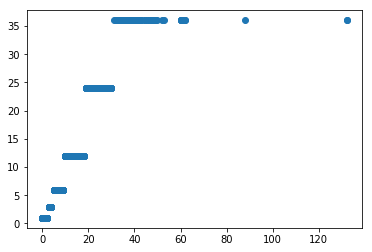

In [110]:
plt.scatter(df_A['months'], df_A['rebill_months'])

## Grouping the dataframe by rebill_months

In [111]:
# drop what we dont need
df_A.drop(columns = ['start_date', 'end_date', 'month_interval', 'months'], axis=1, inplace=True)

In [112]:
df_A.sample(10)

,currency,BU,period,amount,start_date_str,end_date_str,rebill_months
83079,JPY,Document Cloud,2016-02,-825.00,20160106,20160205,1.0
36129,EUR,Document Cloud,2016-11,-5.17,20161010,20170205,3.0
78991,GBP,Document Cloud,2018-11,-6.24,20181014,20190220,3.0
188807,USD,Document Cloud,2017-12,-2.16,20171107,20171210,1.0
84559,JPY,Document Cloud,2016-10,-250.00,20160930,20161107,1.0
6658,AUD,Document Cloud,2016-07,-24.97,20160520,20170519,12.0
132543,USD,Document Cloud,2016-12,-32.90,20161104,20170804,6.0
201321,USD,Document Cloud,2018-02,-16.93,20180103,20180918,6.0
109858,USD,Document Cloud,2015-08,-26.05,20141022,20151021,12.0
24816,DKK,Document Cloud,2015-06,8046.00,20150429,20160428,12.0


In [113]:
df_A['rebill_months'].value_counts()


12.0    107348
6.0      66637
1.0      57684
3.0      23258
24.0       692
36.0       546
Name: rebill_months, dtype: int64

In [114]:
#gb_A = df_A.groupby(['currency', 'BU', 'period'], as_index=False).sum()
# The code above adds the months as well. I do not want this.

In [115]:
#medals = df.pivot_table('no of medals', ['Year', 'Country'], 'medal')
temp = df_A.pivot_table('amount', ['currency', 'BU', 'period'], 'rebill_months')

In [116]:
temp.fillna(0)

rebill_months                                1.0           3.0   \
currency BU                 period                                
AUD      Creative           2015-06   7410.857222  4.127300e+02   
                            2015-08   7284.192982  2.570450e+02   
                            2015-09   7122.768056  0.000000e+00   
                            2015-10   6726.175517  1.281800e+02   
                            2015-11   6896.387241  4.500000e+02   
                            2015-12   6904.457222  3.000000e+02   
                            2016-01    -11.984000  0.000000e+00   
                            2016-02   6664.847500  2.890900e+02   
                            2016-03   6219.013333  0.000000e+00   
                            2016-05   6710.357931  1.281800e+02   
                            2016-06   6174.654531  0.000000e+00   
                            2016-07   6045.849310  1.281800e+02   
                            2016-08   6202.775862  0.000000e+00   
                            2016-09   5923.717778  0.000000e+00   
                            2016-10   5948.620000  1.281800e+02   
                            2016-11   5906.068276  0.000000e+00   
                            2016-12  11460.629459  0.000000e+00   
                            2017-02  -5889.663611  0.000000e+00   
                            2017-03   5834.551828  2.140900e+02   
                            2017-04   6343.430000  1.281800e+02   
                            2017-05   5615.712414  0.000000e+00   
                            2017-06   5477.573684  0.000000e+00   
                            2017-07    -12.990000  0.000000e+00   
                            2017-08   5664.959828  1.281800e+02   
                            2017-09   5736.605278  0.000000e+00   
                            2017-10   5362.475161  1.281800e+02   
                            2017-11   5882.615333  0.000000e+00   
                            2017-12   5921.575405  0.000000e+00   
                            2018-01   -597.660000  0.000000e+00   
                            2018-02    -12.990000  0.000000e+00   
...                                           ...           ...   
USD      Print & Publishing 2017-01   1482.777368  0.000000e+00   
                            2017-02   7798.284500 -3.683486e+04   
                            2017-03  14890.670241  1.947836e+06   
                            2017-04  10346.872667  5.770000e+01   
                            2017-05   3534.248214  6.486607e+05   
                            2017-06  45544.731628  1.137298e+06   
                            2017-07  10565.250357  1.525000e+04   
                            2017-08  29010.683333  1.936700e+06   
                            2017-09  94512.310000  1.473558e+05   
                            2017-10   2436.216000  1.875000e+04   
                            2017-11   9983.796452  1.480686e+06   
                            2017-12  92513.191500  2.195211e+05   
                            2018-01   1321.538462  5.917000e+01   
                            2018-02   9568.044848  0.000000e+00   
                            2018-03  93621.795000  1.530189e+06   
                            2018-04   7436.793103  0.000000e+00   
                            2018-05  32862.976071  2.119800e+03   
                            2018-06  81976.712222  2.158825e+06   
                            2018-07  29558.214286  1.950640e+04   
                            2018-08  18863.692258  1.609095e+04   
                            2018-09  74664.437209  1.460916e+06   
                            2018-10   8797.135172  8.076400e+02   
                            2018-11  35892.827586  2.153162e+06   
                            2018-12  25516.156765  0.000000e+00   
                            2019-01   2867.777778  0.000000e+00   
                            2019-02  14035.777619  0.000000e+00   
                            2019-03   2515.8064

In [117]:
temp.rename(columns = {1.0: 'one_month', 3.0:'three_months',
                                 6.0:'six_months', 12.0:'twelve_months',
                                 24.0:'two_years', 36.0:'three_years'}, inplace=True)


In [118]:
temp.columns

Index(['one_month', 'three_months', 'six_months', 'twelve_months', 'two_years',
       'three_years'],
      dtype='object', name='rebill_months')

In [119]:
df.head()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
0,AUD,Creative,2015-06,490156.86,0.0,0.0,0.0,4992688.95,0.0,0.0,5828107.10,26443.20
1,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4115986.40,0.0,0.0,4815641.33,10399.50
2,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4115986.40,0.0,0.0,2865238.06,10399.50
3,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4365814.67,0.0,0.0,3857333.34,2316.62
4,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4365814.67,0.0,0.0,2793984.26,2316.62


In [120]:
# now I need to combine the new dataframe (df_A) with df
df_merged = pd.merge(df, temp, how='outer', 
                 left_on=['curr', 'BU', 'period'],
                right_on=['currency', 'BU', 'period'])
df_merged = df_merged.fillna(value=0)

In [121]:
df_merged.head()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y,one_month,three_months,six_months,twelve_months,two_years,three_years
0,AUD,Creative,2015-06,490156.86,0.0,0.0,0.0,4992688.95,0.0,0.0,5828107.10,26443.20,7410.857222,412.730,0.0,4954.487778,608.377500,0.0
1,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4115986.40,0.0,0.0,4815641.33,10399.50,0.000000,0.000,0.0,0.000000,0.000000,0.0
2,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4115986.40,0.0,0.0,2865238.06,10399.50,0.000000,0.000,0.0,0.000000,0.000000,0.0
3,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4365814.67,0.0,0.0,3857333.34,2316.62,7284.192982,257.045,0.0,5985.608103,648.305882,0.0
4,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4365814.67,0.0,0.0,2793984.26,2316.62,7284.192982,257.045,0.0,5985.608103,648.305882,0.0


In [122]:
df_merged['deferred_1M'] = df_merged['deferred_1M']+df_merged['one_month']
df_merged.drop(labels=['one_month'], axis=1, inplace=True)


In [123]:
df_merged.head()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y,three_months,six_months,twelve_months,two_years,three_years
0,AUD,Creative,2015-06,490156.86,0.0,0.0,0.0,5.000100e+06,0.0,0.0,5828107.10,26443.20,412.730,0.0,4954.487778,608.377500,0.0
1,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4.115986e+06,0.0,0.0,4815641.33,10399.50,0.000,0.0,0.000000,0.000000,0.0
2,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4.115986e+06,0.0,0.0,2865238.06,10399.50,0.000,0.0,0.000000,0.000000,0.0
3,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4.373099e+06,0.0,0.0,3857333.34,2316.62,257.045,0.0,5985.608103,648.305882,0.0
4,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4.373099e+06,0.0,0.0,2793984.26,2316.62,257.045,0.0,5985.608103,648.305882,0.0


In [124]:
df_merged['deferred_3M'] = df_merged['deferred_3M']+df_merged['three_months']
df_merged.drop(labels=['three_months'], axis=1, inplace=True)

df_merged['deferred_6M'] = df_merged['deferred_6M']+df_merged['six_months']
df_merged.drop(labels=['six_months'], axis=1, inplace=True)

df_merged['deferred_1Y'] = df_merged['deferred_1Y']+df_merged['twelve_months']
df_merged.drop(labels=['twelve_months'], axis=1, inplace=True)

df_merged['deferred_2Y'] = df_merged['deferred_2Y']+df_merged['two_years']
df_merged.drop(labels=['two_years'], axis=1, inplace=True)

df_merged['deferred_3Y'] = df_merged['deferred_3Y']+df_merged['three_years']
df_merged.drop(labels=['three_years'], axis=1, inplace=True)



In [125]:
df_merged.head()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
0,AUD,Creative,2015-06,490156.86,0.0,0.0,0.0,5.000100e+06,412.730,0.0,5.833062e+06,27051.577500
1,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4.115986e+06,0.000,0.0,4.815641e+06,10399.500000
2,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4.115986e+06,0.000,0.0,2.865238e+06,10399.500000
3,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4.373099e+06,257.045,0.0,3.863319e+06,2964.925882
4,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4.373099e+06,257.045,0.0,2.799970e+06,2964.925882


In [126]:
df_merged.columns

Index(['curr', 'BU', 'period', 'recognized', 'service', 'deferred_B',
       'deferred_3Y', 'deferred_1M', 'deferred_3M', 'deferred_6M',
       'deferred_1Y', 'deferred_2Y'],
      dtype='object')

In [127]:
df_merged.head()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
0,AUD,Creative,2015-06,490156.86,0.0,0.0,0.0,5.000100e+06,412.730,0.0,5.833062e+06,27051.577500
1,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4.115986e+06,0.000,0.0,4.815641e+06,10399.500000
2,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4.115986e+06,0.000,0.0,2.865238e+06,10399.500000
3,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4.373099e+06,257.045,0.0,3.863319e+06,2964.925882
4,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4.373099e+06,257.045,0.0,2.799970e+06,2964.925882


In [128]:
df_merged.tail()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
4316,0,Other Solutions,2018-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32891.96,0.0
4317,0,Other Solutions,2015-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28800.00,0.0
4318,0,Other Solutions,2015-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23580.00,0.0
4319,0,Other Solutions,2016-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21600.00,0.0
4320,0,Other Solutions,2017-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33934.80,0.0


In [129]:
df_merged['deferred_3M'].describe()

count    4.321000e+03
mean     4.495532e+06
std      1.007681e+07
min     -1.001754e+06
25%      0.000000e+00
50%      0.000000e+00
75%      1.631312e+06
max      4.392479e+07
Name: deferred_3M, dtype: float64

# Currency Map

In [130]:
curr_map = pd.read_excel('../data/Data_2019_P06/currency_map.xlsx', 'curr_map')


In [131]:
curr_map['Country'] = curr_map['Country'].map(lambda x: str(x)[:-4])
curr_map

,Country,Curr
0,Aus and New Zealand,AUD
1,Benelux,EUR
2,Brazil,USD
3,Canada,USD
4,China,USD
5,Eastern Europe,EUR
6,France,EUR
7,Germany,EUR
8,Hong Kong,USD
9,Iberica,EUR


In [132]:
curr_map.set_index('Country', inplace=True)

In [133]:
curr_map

,Curr
Country,
Aus and New Zealand,AUD
Benelux,EUR
Brazil,USD
Canada,USD
China,USD
Eastern Europe,EUR
France,EUR
Germany,EUR
Hong Kong,USD


In [134]:
test['Currency']['United States']

NameError: name 'test' is not defined

In [ ]:
model_dict


In [ ]:
model_dict['add_this']= 7

### Forward Rates

In [ ]:
FX_rates = pd.read_excel('../data/Data_2019_P06/FX_data.xlsx', 'to_matlab')

In [ ]:
FX_rates


In [ ]:
print(i) #JTLWASHERE